In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow opencv-python-headless matplotlib numpy

In [3]:
# Directorios en Google Drive
train_dir = '/content/drive/MyDrive/IA/train'
validation_dir = '/content/drive/MyDrive/IA/valid'
test_dir = '/content/drive/MyDrive/IA/test'


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

def load_data(image_dir, annotation_csv):
    data = pd.read_csv(annotation_csv)
    images = []
    targets = []

    for _, row in data.iterrows():
        image_path = os.path.join(image_dir, row['filename'])
        if os.path.exists(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, [128, 128])
            image = image / 255.0

            # Normalizar las coordenadas del cuadro delimitador
            xmin = row['xmin'] / row['width']
            ymin = row['ymin'] / row['height']
            xmax = row['xmax'] / row['width']
            ymax = row['ymax'] / row['height']
            boxes = [xmin, ymin, xmax - xmin, ymax - ymin]

            images.append(image)
            targets.append(boxes)

    return np.array(images), np.array(targets)

train_image_dir = '/content/drive/MyDrive/IA/train'
train_annotation_csv = '/content/drive/MyDrive/IA/train/_annotations.csv'
val_image_dir = '/content/drive/MyDrive/IA/valid'
val_annotation_csv = '/content/drive/MyDrive/IA/valid/_annotations.csv'

X_train, y_train = load_data(train_image_dir, train_annotation_csv)
X_val, y_val = load_data(val_image_dir, val_annotation_csv)

print(f'Train images: {X_train.shape}, Train targets: {y_train.shape}')
print(f'Validation images: {X_val.shape}, Validation targets: {y_val.shape}')


Train images: (7959, 128, 128, 3), Train targets: (7959, 4)
Validation images: (465, 128, 128, 3), Validation targets: (465, 4)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

def create_model():
    model = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4)  # Salida: coordenadas del cuadro delimitador (xmin, ymin, ancho, alto)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

model = create_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 128)      

In [6]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))


Epoch 1/10
249/249 [==============================] - 11s 24ms/step - loss: 0.0627 - val_loss: 0.0178
Epoch 2/10
249/249 [==============================] - 4s 18ms/step - loss: 0.0199 - val_loss: 0.0179
Epoch 3/10
249/249 [==============================] - 4s 18ms/step - loss: 0.0189 - val_loss: 0.0162
Epoch 4/10
249/249 [==============================] - 5s 20ms/step - loss: 0.0180 - val_loss: 0.0170
Epoch 5/10
249/249 [==============================] - 4s 18ms/step - loss: 0.0178 - val_loss: 0.0153
Epoch 6/10
249/249 [==============================] - 4s 18ms/step - loss: 0.0174 - val_loss: 0.0161
Epoch 7/10
249/249 [==============================] - 5s 21ms/step - loss: 0.0174 - val_loss: 0.0154
Epoch 8/10
249/249 [==============================] - 5s 19ms/step - loss: 0.0172 - val_loss: 0.0152
Epoch 9/10
249/249 [==============================] - 5s 18ms/step - loss: 0.0171 - val_loss: 0.0151
Epoch 10/10
249/249 [==============================] - 5s 20ms/step - loss: 0.0171 - val_l

1/1 [==============================] - 0s 311ms/step


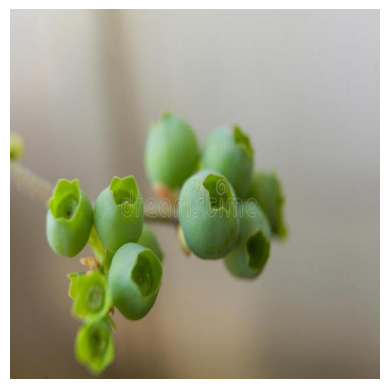

In [7]:
import matplotlib.pyplot as plt
import cv2
def predecir_arandanos(image, model):
    resized_image = tf.image.resize(image, (128, 128))
    input_image = np.expand_dims(resized_image, axis=0)

    pred = model.predict(input_image)[0]
    xmin, ymin, w, h = pred

    h_ratio = image.shape[0] / 128
    w_ratio = image.shape[1] / 128

    xmin = int(xmin * image.shape[1])
    ymin = int(ymin * image.shape[0])
    w = int(w * image.shape[1])
    h = int(h * image.shape[0])

    return (xmin, ymin, w, h)

def draw_bounding_box(image, box):
    xmin, ymin, w, h = box
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (xmin, ymin), (xmin + w, ymin + h), (0, 255, 0), 2)
    return image_with_box

example_image_path = '/content/drive/MyDrive/IA/valid/arandanoBlanco-65-_jpg.rf.b5374513892ff730a0d810f215857456.jpg'
example_image = cv2.imread(example_image_path)
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

box = predecir_arandanos(example_image, model)
image_with_box = draw_bounding_box(example_image, box)

plt.imshow(image_with_box)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 17ms/step


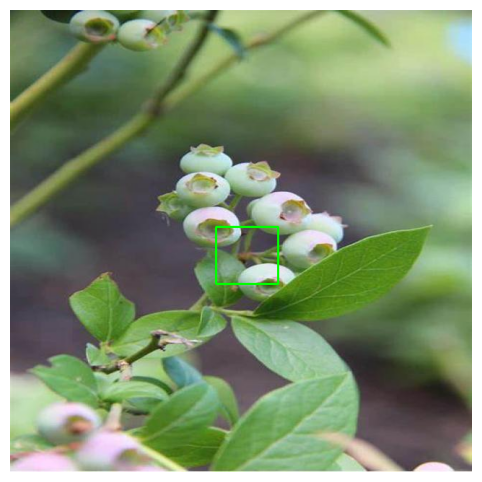

In [8]:
import cv2
import matplotlib.pyplot as plt

# Función para predecir arándanos y dibujar cuadro delimitador
def predict_and_draw(image_path, model):
    # Leer la imagen
    image = cv2.imread(image_path)
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocesar la imagen para hacer la predicción
    resized_image = cv2.resize(original_image, (128, 128))
    input_image = np.expand_dims(resized_image, axis=0)
    input_image = input_image / 255.0

    # Realizar la predicción
    pred = model.predict(input_image)[0]
    xmin, ymin, w, h = pred

    # Escalar las coordenadas para la imagen original
    h_ratio = original_image.shape[0] / 128
    w_ratio = original_image.shape[1] / 128

    xmin = int(xmin * original_image.shape[1])
    ymin = int(ymin * original_image.shape[0])
    w = int(w * original_image.shape[1])
    h = int(h * original_image.shape[0])

    # Dibujar el cuadro delimitador en la imagen original
    cv2.rectangle(original_image, (xmin, ymin), (xmin + w, ymin + h), (0, 255, 0), 2)

    # Mostrar la imagen con el cuadro delimitador
    plt.figure(figsize=(8, 6))
    plt.imshow(original_image)
    plt.axis('off')
    plt.show()

# Ejemplo de uso:
example_image_path = '/content/drive/MyDrive/IA/valid/arandanoBlanco-215-_jpg.rf.7060f15c1116857c83575180492411e1.jpg'
predict_and_draw(example_image_path, model)


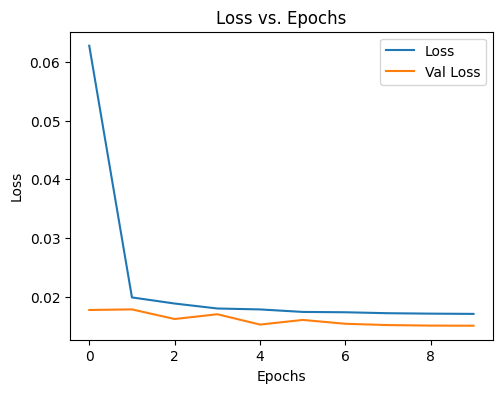

In [17]:
import matplotlib.pyplot as plt

# Graficar loss y mean_absolute_error
plt.figure(figsize=(12, 4))

# Gráfico de la pérdida (loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

